## Upload Model to HF

In [ ]:
from transformers import AutoModel,AutoTokenizer

model = AutoModel.from_pretrained('../models/honeypot-llama3-8B')
tokenizer = AutoTokenizer.from_pretrained('../models/honeypot-llama3-8B')

model.push_to_hub("honeypot-llama3-8B")
tokenizer.push_to_hub("honeypot-llama3-8B")

## LLM Inference

In [29]:
import torch
import gc
import re
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline
)

class LLM:
    def __init__(self, model_name="NousResearch/Meta-Llama-3-8B-Instruct"):
        gc.collect()
        torch.cuda.empty_cache()
        print("Cleared GPU...")

        self.DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"
        self.BASE_MODEL_NAME = model_name
        self.SYSTEM_PROMPT = "You are mimicking a linux server. Respond with what the terminal would respond when a code given. I want you to only reply with the terminal outputs inside one unique code block and nothing else. Do not write any explanations. Do not type any commands unless I instruct you to do so."

        # Model configuration
        self.pipeline = pipeline(
            "text-generation",
            model=self.BASE_MODEL_NAME,
            tokenizer=self.BASE_MODEL_NAME,
            model_kwargs={"torch_dtype": torch.bfloat16},
            device=self.DEVICE,
        )

        print("Loaded Model: ", self.BASE_MODEL_NAME)

    def answer(self, query, log_history=[], max_tokens=4096, temperature=0.01, top_p=0.8):

        message_history = [{"role": "system", "content": self.SYSTEM_PROMPT}]
        if len(log_history) > 0:
            for i, item in enumerate(log_history):
                if i % 2 == 0:
                    message_history.append({"role": "user", "content": item})
                else:
                    message_history.append({"role": "assistant", "content": item})

        user_prompt = message_history + [{"role": "user", "content": query}]
        prompt = self.pipeline.tokenizer.apply_chat_template(
            user_prompt, tokenize=False, add_generation_prompt=True
        )
        outputs = self.pipeline(
            prompt,
            max_new_tokens=max_tokens,
            eos_token_id=self.pipeline.tokenizer.eos_token_id,
            do_sample=True,
            temperature=temperature,
            top_p=top_p,
        )
        response = outputs[0]["generated_text"][len(prompt):]

        # remove unnecessary quotes
        if response.startswith("```") and response.endswith("```"):
            response = response[3:-3]
        elif response.startswith("`") and response.endswith("`"):
            response = response[1:-1]
        
        return response
    

llama = LLM("../models/honeypot-llama3-8B")
#print(llama.answer('ls -al', ['mkdir test_directory; touch test.txt','\n']))

Cleared GPU...


Loading checkpoint shards: 100%|██████████| 17/17 [00:05<00:00,  3.38it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded Model:  ../models/honeypot-llama3-8B


## Evaluation

In [52]:
from openai import OpenAI

client = OpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio")


def measure_correctness(prompt, command, generated_answer, reference_answer):
    try:
        correctness_prompt = f"""###Task Description: An instruction (might include an Input inside it), a query, a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing a evaluation criteria are given. 
        1. Write a detailed feedback that assesses the quality of the response strictly based on the given score rubric, not evaluating in general. 
        2. After writing a feedback, write a score that is either 1 or 2 or 3 or 4 or 5. You should refer to the score rubric. 
        3. The output format should look as follows: "Feedback: (write a feedback for criteria) [RESULT] (1 or 2 or 3 or 4 or 5)" 
        4. Please do not generate any other opening, closing, and explanations. 
        5. Generated answer and reference answer can be completely different, consider if it makes sense for the given command.
        6. Error messages in the generated answer are fine as long as the reference answer has error messages too.

        ###The instruction to evaluate: Your task is to evaluate the generated answer and reference answer for the query: {prompt}\nCommand:{command}

        ###Generate answer to evaluate: {generated_answer} 

        ###Reference Answer (Score 5): {reference_answer}

        ###Score Rubrics: 
        Score 1: The response is completely irrelevant to the given command.
        Score 2: The response executes the command but provides incomplete or inaccurate information.
        Score 3: The response provides some accurate information but lacks detail or has minor errors.
        Score 4: The response provides mostly accurate and complete information but has some minor errors or omissions.
        Score 5: The response provides a complete and accurate response to the given command, identical to what a Linux terminal would output.
        
        ###Feedback:"""

        completion = client.chat.completions.create(
            model="RichardErkhov/prometheus-eval_-_prometheus-7b-v2.0-gguf",
            messages=[
                {"role": "system", "content": "You are a language model evaluator. Respond according to the given task."},
                {"role": "user", "content": correctness_prompt}
            ],
            temperature=0.01,
        )

        return int(completion.choices[0].message.content.split('[RESULT] ')[1])
    except:
        return -1

In [53]:
prompt = 'You are mimicking a linux server. Respond with what the terminal would respond when a code given. I want you to only reply with the terminal outputs inside one unique code block and nothing else. Do not write any explanations. Do not type any commands unless I instruct you to do so.'
command = 'ls'
generated_answer = 'bin  boot  dev  etc  home '
reference_answer = 'bin  boot  dev  etc  home  lib  lib64  lost+found  media  mnt  opt  proc  root  run  sbin  srv  sys  tmp  usr  var'

measure_correctness(prompt, command, generated_answer, reference_answer)

2

In [72]:
import pandas as pd
from datasets import load_dataset
from tqdm import tqdm
import time
import spacy
import signal
nlp = spacy.load("en_core_web_sm")

dataset = load_dataset("hotal/honeypot_logs")
df = pd.DataFrame(dataset['train'])[:334].sample(n=150, random_state=42)

def timeout_handler(signum, frame):
    raise TimeoutError

for index, row in tqdm(df.iterrows()):
    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(15)  # 10 seconds
    try:
        df.loc[index, 'generated'] = llama.answer(row['command'], [])
    except TimeoutError:
        print(f"Skipping row {index} due to timeout (> 15 seconds)")
        df.loc[index, 'generated'] = None
    finally:
        signal.alarm(0)  # reset the alarm

df


12it [00:28,  6.20s/it]

Skipping row 9 due to timeout (> 15 seconds)


16it [00:45,  6.26s/it]

Skipping row 132 due to timeout (> 15 seconds)


42it [01:32,  5.52s/it]

Skipping row 42 due to timeout (> 15 seconds)


60it [02:28,  9.42s/it]

Skipping row 179 due to timeout (> 15 seconds)


67it [02:58,  6.99s/it]

Skipping row 60 due to timeout (> 15 seconds)


76it [03:24,  5.86s/it]

Skipping row 177 due to timeout (> 15 seconds)


90it [03:50,  3.73s/it]

Skipping row 185 due to timeout (> 15 seconds)


142it [05:04,  4.91s/it]

Skipping row 221 due to timeout (> 15 seconds)


150it [05:30,  2.20s/it]

Skipping row 222 due to timeout (> 15 seconds)


,system,command,response,generated
25,You are mimicking a linux server. Respond with...,ps,PID TTY TIME COMMAND ...,\n PID TTY TIME CMD\n 1234 pts/0 ...
309,You are mimicking a linux server. Respond with...,uptime -u,"18:42:29 up 3:14, 1 user, load average: 0....",\n 00:00:00\n
73,You are mimicking a linux server. Respond with...,"chmod u+rw /home/phil/file_or_directory1,/home...",chmod: cannot access '/home/phil/file_or_direc...,\nchmod: cannot access '/home/phil/file_or_dir...
195,You are mimicking a linux server. Respond with...,mv /home/phil/source/myfile.txt /home/phil/tar...,mv: cannot create regular file `/home/phil/tar...,mv: cannot move '/home/phil/source/myfile.txt'...
57,You are mimicking a linux server. Respond with...,cat /test2,ELF,cat: /test2: No such file or directory
...,...,...,...,...
283,You are mimicking a linux server. Respond with...,uname -h,uname: invalid option -- 'h'\nTry 'uname --hel...,Linux
148,You are mimicking a linux server. Respond with...,gcc -Wall -O2 -o path/to/output_executable pat...,gcc: path/to/source.cpp: No such file or direc...,\ngcc: error: path/to/output_executable: No su...
291,You are mimicking a linux server. Respond with...,uptime,"18:42:08 up 3:13, 1 user, load average: 0....","\n 21:34:12 up 2 days, 1:04, 1 user, load a..."
239,You are mimicking a linux server. Respond with...,rmdir -p /home/phil/directory1 /home/phil/dire...,rmdir: failed to remove `-p': No such file or ...,\nrmdir: failed to remove `/home/phil/director...


In [78]:
def measure_similarity(sentence1, sentence2):
    try:
        doc1 = nlp(sentence1)
        doc2 = nlp(sentence2)
        similarity = doc1.similarity(doc2)
        return similarity
    except Exception as e:
        return -1

results = []
for index, row in tqdm(df.iterrows()):
    
    prompt = row['system']
    command = row['command']
    reference_answer = row['response']
    generated_answer = row['generated']

    #result = measure_correctness(prompt, command, generated_answer, reference_answer)
    result = measure_similarity(generated_answer, reference_answer)
    if result != -1:
        results.append(result)
    #time.sleep(0.05)

results

0it [00:00, ?it/s]/tmp/ipykernel_1638383/3606016577.py:5: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  similarity = doc1.similarity(doc2)
150it [00:01, 130.00it/s]


[0.9266226889377728,
 0.7483038693015535,
 0.9854740744166057,
 0.8750943762180343,
 0.1222527798910181,
 0.9599760967911799,
 0.15790873052795754,
 0.3427842031666325,
 0.8901137910677026,
 0.9250525849039357,
 0.6146497515738819,
 0.6783382553049272,
 0.9551248995922451,
 0.627599031453704,
 0.8775345504719663,
 0.8153339463875003,
 0.43039500631938543,
 0.4415520404516888,
 0.6499677098298162,
 0.7572771114785681,
 0.7478363709157725,
 0.517494247868626,
 0.5214024835335245,
 0.5217871483441932,
 0.4151627115886709,
 0.7464344056291038,
 0.5545979492340203,
 0.7469779958000291,
 0.3084552815614088,
 0.9770636258190092,
 0.42111358743318955,
 0.508898890243933,
 0.4691406705359161,
 0.8500015026444628,
 0.7013135151145201,
 0.9176107960715111,
 0.8260988634215954,
 0.47781991339817054,
 0.41822584352315856,
 0.40500443370038985,
 0.6149629113333346,
 0.672761011302793,
 0.9757408913151834,
 0.7929636702502307,
 0.28980344659973345,
 0.5850302585113578,
 0.5611672372311479,
 0.8562951

## Visualizations

In [113]:
import numpy as np
np.array(results).mean(), len(results)

(0.6885405904371525, 140)

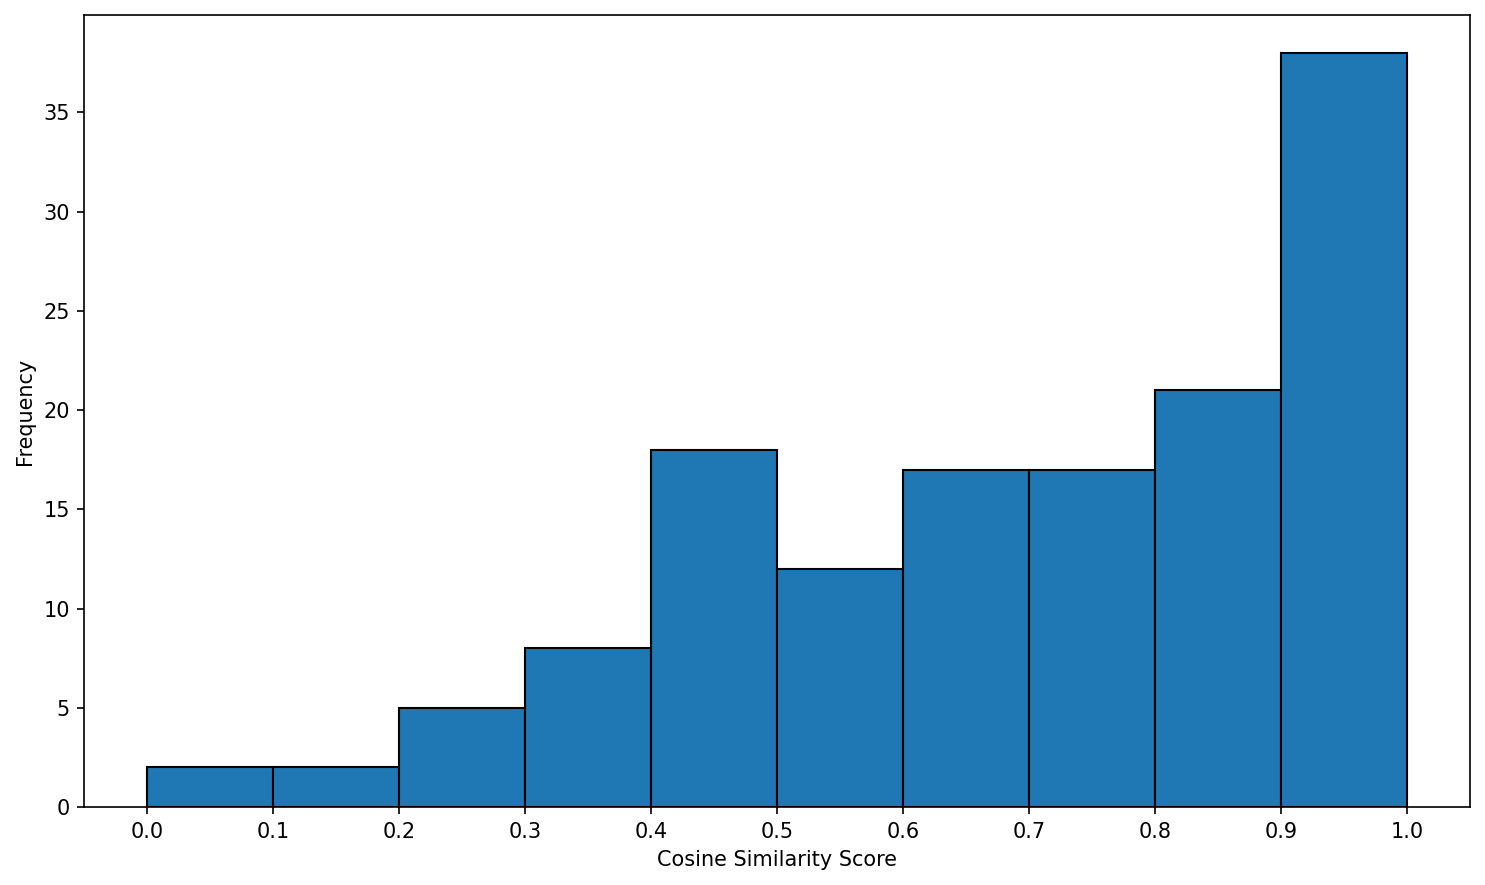

In [146]:
import matplotlib.pyplot as plt
  
n, bins = np.histogram(results, bins=np.arange(0, 1.1, 0.1))
plt.figure(figsize=(10, 6), dpi=150)
plt.bar(bins[:-1], n, width=0.1, align='edge', edgecolor='black')
plt.xticks(np.arange(0, 1.1, 0.1))
  
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')

#plt.title('Similarity Score Distribution between Generated and Reference Output ', fontweight = "bold")
plt.tight_layout()
plt.savefig('similarity_score_distribution_140samples.png')
plt.show()


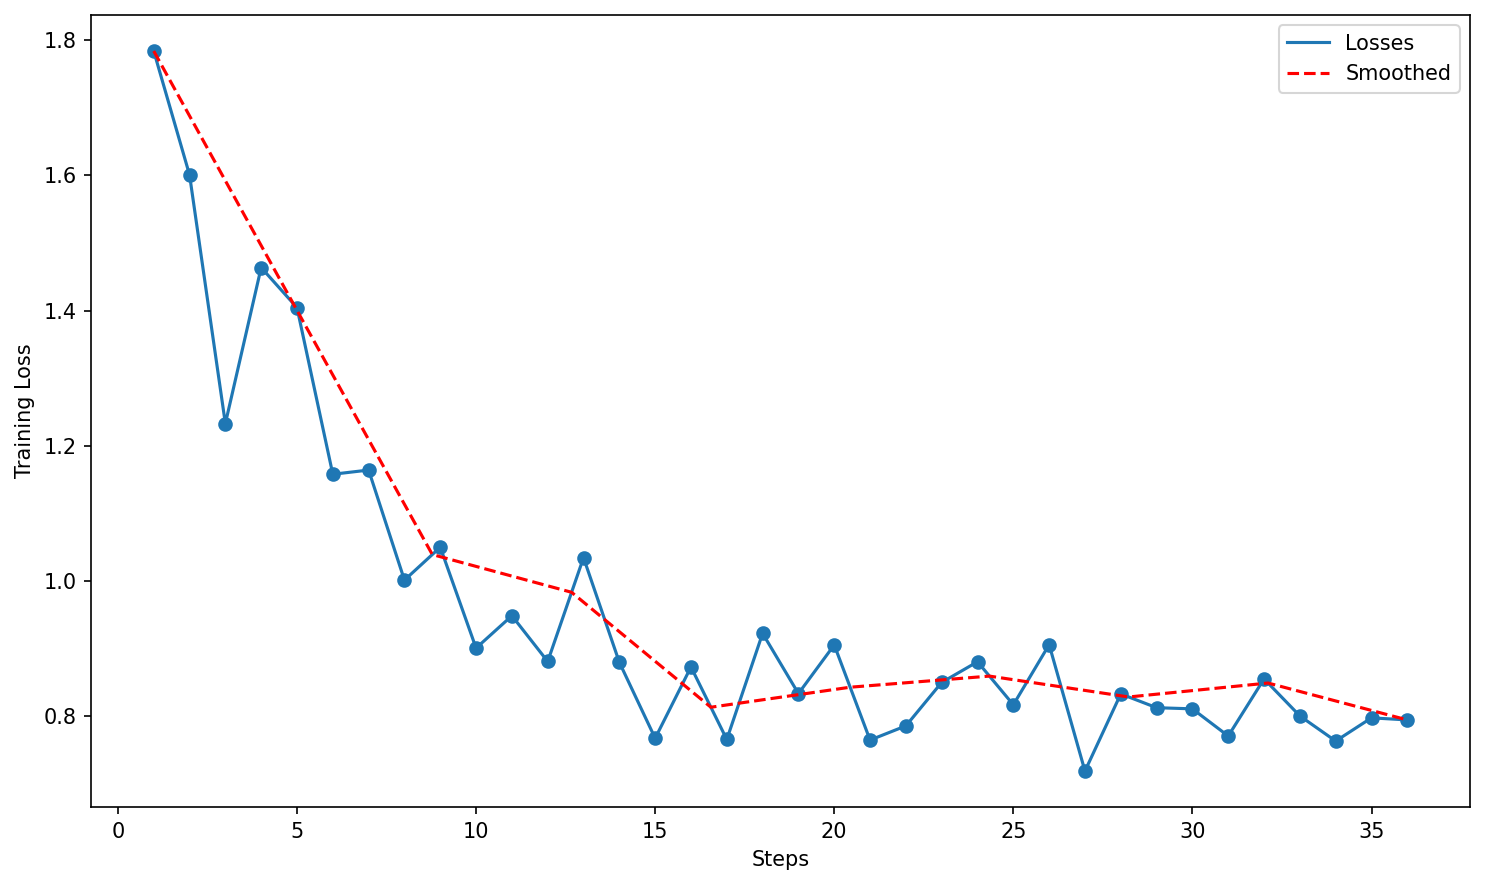

In [145]:
logs = [
    {"current_steps": 1, "total_steps": 36, "loss": 1.7841, "learning_rate": 0.0004990486745229364, "epoch": 0.1, "percentage": 2.78, "elapsed_time": "0:00:18", "remaining_time": "0:11:00"},
{"current_steps": 2, "total_steps": 36, "loss": 1.6008, "learning_rate": 0.000496201938253052, "epoch": 0.2, "percentage": 5.56, "elapsed_time": "0:00:35", "remaining_time": "0:09:59"},
{"current_steps": 3, "total_steps": 36, "loss": 1.2327, "learning_rate": 0.0004914814565722671, "epoch": 0.3, "percentage": 8.33, "elapsed_time": "0:00:56", "remaining_time": "0:10:26"},
{"current_steps": 4, "total_steps": 36, "loss": 1.4636, "learning_rate": 0.0004849231551964771, "epoch": 0.41, "percentage": 11.11, "elapsed_time": "0:01:08", "remaining_time": "0:09:09"},
{"current_steps": 5, "total_steps": 36, "loss": 1.4043, "learning_rate": 0.00047657694675916254, "epoch": 0.51, "percentage": 13.89, "elapsed_time": "0:01:22", "remaining_time": "0:08:31"},
{"current_steps": 6, "total_steps": 36, "loss": 1.1577, "learning_rate": 0.00046650635094610973, "epoch": 0.61, "percentage": 16.67, "elapsed_time": "0:01:51", "remaining_time": "0:09:18"},
{"current_steps": 7, "total_steps": 36, "loss": 1.1639, "learning_rate": 0.00045478801107224796, "epoch": 0.71, "percentage": 19.44, "elapsed_time": "0:02:05", "remaining_time": "0:08:40"},
{"current_steps": 8, "total_steps": 36, "loss": 1.001, "learning_rate": 0.0004415111107797445, "epoch": 0.81, "percentage": 22.22, "elapsed_time": "0:02:22", "remaining_time": "0:08:18"},
{"current_steps": 9, "total_steps": 36, "loss": 1.0497, "learning_rate": 0.00042677669529663686, "epoch": 0.91, "percentage": 25.0, "elapsed_time": "0:02:37", "remaining_time": "0:07:53"},
{"current_steps": 10, "total_steps": 36, "loss": 0.9004, "learning_rate": 0.0004106969024216348, "epoch": 1.01, "percentage": 27.78, "elapsed_time": "0:03:00", "remaining_time": "0:07:49"},
{"current_steps": 11, "total_steps": 36, "loss": 0.9483, "learning_rate": 0.00039339410908776154, "epoch": 1.11, "percentage": 30.56, "elapsed_time": "0:03:13", "remaining_time": "0:07:19"},
{"current_steps": 12, "total_steps": 36, "loss": 0.8806, "learning_rate": 0.000375, "epoch": 1.22, "percentage": 33.33, "elapsed_time": "0:03:28", "remaining_time": "0:06:57"},
{"current_steps": 13, "total_steps": 36, "loss": 1.0342, "learning_rate": 0.00035565456543517487, "epoch": 1.32, "percentage": 36.11, "elapsed_time": "0:03:43", "remaining_time": "0:06:35"},
{"current_steps": 14, "total_steps": 36, "loss": 0.8794, "learning_rate": 0.0003355050358314172, "epoch": 1.42, "percentage": 38.89, "elapsed_time": "0:04:06", "remaining_time": "0:06:26"},
{"current_steps": 15, "total_steps": 36, "loss": 0.767, "learning_rate": 0.00031470476127563017, "epoch": 1.52, "percentage": 41.67, "elapsed_time": "0:04:27", "remaining_time": "0:06:14"},
{"current_steps": 16, "total_steps": 36, "loss": 0.8725, "learning_rate": 0.00029341204441673266, "epoch": 1.62, "percentage": 44.44, "elapsed_time": "0:04:41", "remaining_time": "0:05:51"},
{"current_steps": 17, "total_steps": 36, "loss": 0.7652, "learning_rate": 0.0002717889356869146, "epoch": 1.72, "percentage": 47.22, "elapsed_time": "0:05:09", "remaining_time": "0:05:45"},
{"current_steps": 18, "total_steps": 36, "loss": 0.9222, "learning_rate": 0.00025, "epoch": 1.82, "percentage": 50.0, "elapsed_time": "0:05:34", "remaining_time": "0:05:34"},
{"current_steps": 19, "total_steps": 36, "loss": 0.8331, "learning_rate": 0.00022821106431308543, "epoch": 1.92, "percentage": 52.78, "elapsed_time": "0:05:49", "remaining_time": "0:05:12"},
{"current_steps": 20, "total_steps": 36, "loss": 0.9051, "learning_rate": 0.00020658795558326743, "epoch": 2.03, "percentage": 55.56, "elapsed_time": "0:06:02", "remaining_time": "0:04:49"},
{"current_steps": 21, "total_steps": 36, "loss": 0.7643, "learning_rate": 0.0001852952387243698, "epoch": 2.13, "percentage": 58.33, "elapsed_time": "0:06:16", "remaining_time": "0:04:28"},
{"current_steps": 22, "total_steps": 36, "loss": 0.7853, "learning_rate": 0.00016449496416858284, "epoch": 2.23, "percentage": 61.11, "elapsed_time": "0:06:29", "remaining_time": "0:04:07"},
{"current_steps": 23, "total_steps": 36, "loss": 0.8496, "learning_rate": 0.0001443454345648252, "epoch": 2.33, "percentage": 63.89, "elapsed_time": "0:06:53", "remaining_time": "0:03:53"},
{"current_steps": 24, "total_steps": 36, "loss": 0.8802, "learning_rate": 0.00012500000000000006, "epoch": 2.43, "percentage": 66.67, "elapsed_time": "0:07:07", "remaining_time": "0:03:33"},
{"current_steps": 25, "total_steps": 36, "loss": 0.8165, "learning_rate": 0.00010660589091223854, "epoch": 2.53, "percentage": 69.44, "elapsed_time": "0:07:21", "remaining_time": "0:03:14"},
{"current_steps": 26, "total_steps": 36, "loss": 0.9055, "learning_rate": 8.930309757836516e-05, "epoch": 2.63, "percentage": 72.22, "elapsed_time": "0:07:38", "remaining_time": "0:02:56"},
{"current_steps": 27, "total_steps": 36, "loss": 0.7184, "learning_rate": 7.322330470336314e-05, "epoch": 2.73, "percentage": 75.0, "elapsed_time": "0:08:09", "remaining_time": "0:02:43"},
{"current_steps": 28, "total_steps": 36, "loss": 0.8326, "learning_rate": 5.848888922025553e-05, "epoch": 2.84, "percentage": 77.78, "elapsed_time": "0:08:30", "remaining_time": "0:02:25"},
{"current_steps": 29, "total_steps": 36, "loss": 0.8122, "learning_rate": 4.521198892775202e-05, "epoch": 2.94, "percentage": 80.56, "elapsed_time": "0:08:52", "remaining_time": "0:02:08"},
{"current_steps": 30, "total_steps": 36, "loss": 0.8105, "learning_rate": 3.3493649053890325e-05, "epoch": 3.04, "percentage": 83.33, "elapsed_time": "0:09:07", "remaining_time": "0:01:49"},
{"current_steps": 31, "total_steps": 36, "loss": 0.7703, "learning_rate": 2.3423053240837516e-05, "epoch": 3.14, "percentage": 86.11, "elapsed_time": "0:09:22", "remaining_time": "0:01:30"},
{"current_steps": 32, "total_steps": 36, "loss": 0.8548, "learning_rate": 1.5076844803522921e-05, "epoch": 3.24, "percentage": 88.89, "elapsed_time": "0:09:37", "remaining_time": "0:01:12"},
{"current_steps": 33, "total_steps": 36, "loss": 0.8, "learning_rate": 8.51854342773295e-06, "epoch": 3.34, "percentage": 91.67, "elapsed_time": "0:09:59", "remaining_time": "0:00:54"},
{"current_steps": 34, "total_steps": 36, "loss": 0.7628, "learning_rate": 3.798061746947995e-06, "epoch": 3.44, "percentage": 94.44, "elapsed_time": "0:10:17", "remaining_time": "0:00:36"},
{"current_steps": 35, "total_steps": 36, "loss": 0.7972, "learning_rate": 9.513254770636137e-07, "epoch": 3.54, "percentage": 97.22, "elapsed_time": "0:10:31", "remaining_time": "0:00:18"},
{"current_steps": 36, "total_steps": 36, "loss": 0.7941, "learning_rate": 0.0, "epoch": 3.65, "percentage": 100.0, "elapsed_time": "0:10:45", "remaining_time": "0:00:00"}
]

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


plt.figure(figsize=(10, 6), dpi=150)
losses = np.array([x["loss"] for x in logs])
steps = range(1, len(logs)+1)

plt.plot(steps, losses, label='Losses')
plt.scatter(steps, losses)

f_cubic = interp1d(steps, losses)
xnew = np.linspace(1, 36, num=10, endpoint=True)
plt.plot(xnew, f_cubic(xnew), '--', label='Smoothed', c='r')


plt.xlabel('Steps')
plt.ylabel('Training Loss')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('training_loss.png')
plt.show()
